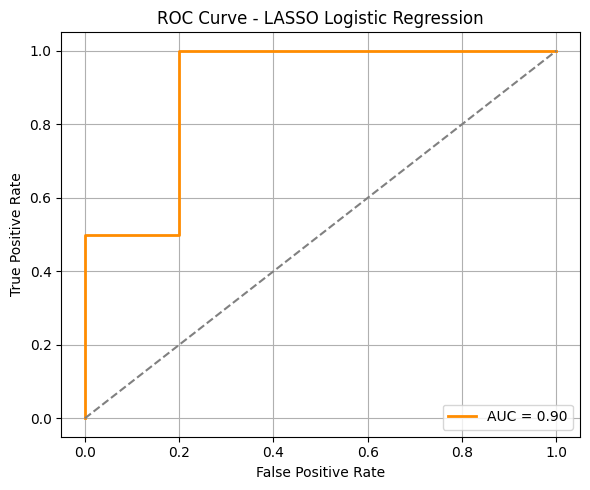

/var/folders/r_/slcx0x417xj828kz4yc651mh0000gn/T/ipykernel_1535/888096084.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')


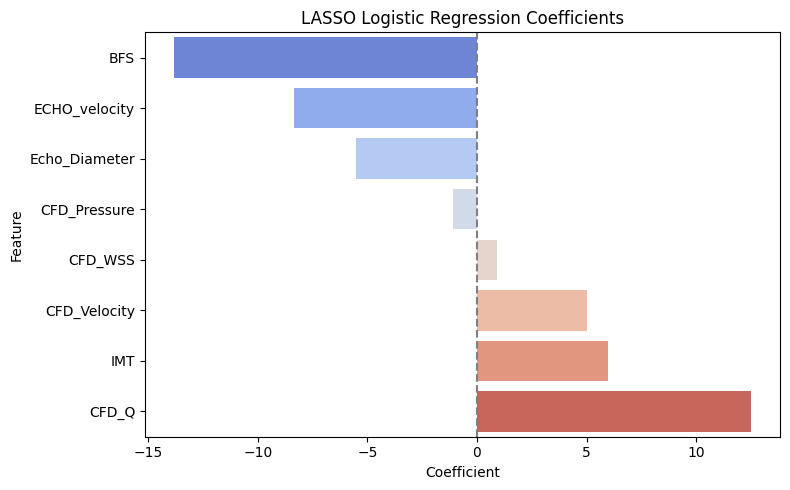

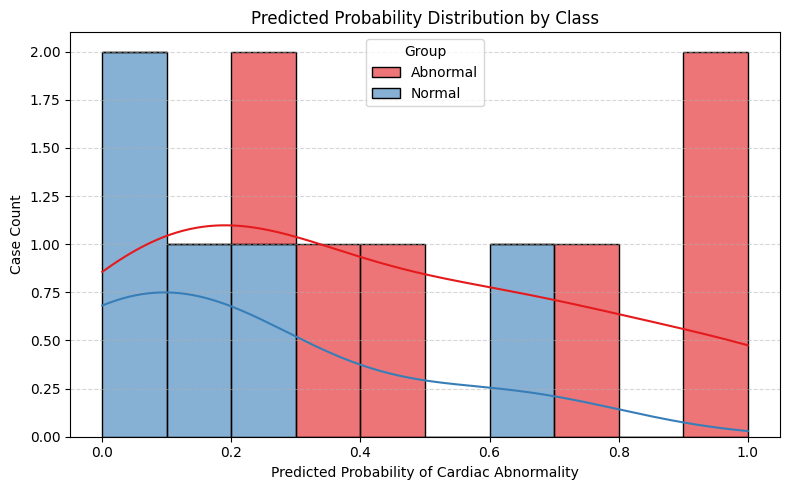

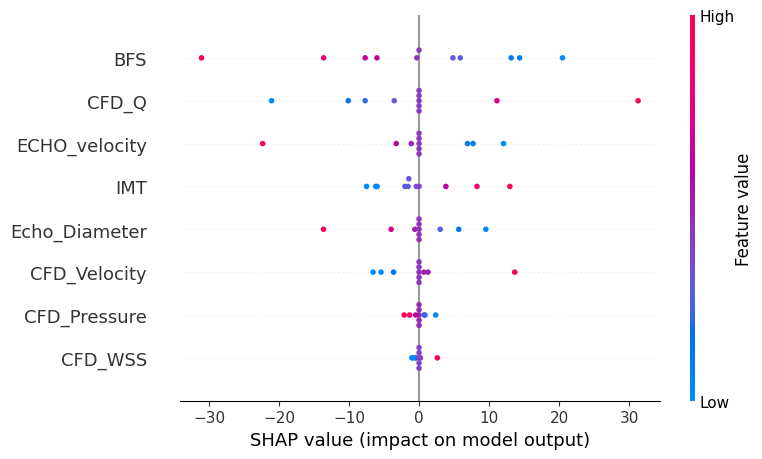

In [3]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# === 创建输出目录结构 ===
os.makedirs("./Figure", exist_ok=True)

# === 步骤 0：加载数据 ===
# 1. 数据加载
df = pd.DataFrame({
    'Case': [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11],
    'GA': [24.71,24.71,24.71,24.14,24.14,24.14,24.00,24.00,24.00,25.43,25.43,25.43,
           26.14,26.14,26.14,28.00,28.00,28.00,26.43,26.43,26.43,35.29,35.29,35.29,
           24.57,24.57,24.57,33.00,33.00,33.00,26.71,26.71,26.71],
    'plane': ['PA','DA','AO']*11,
    'BFS': [17.226,17.221,17.320,17.552,17.144,17.288,17.249,17.173,17.376,17.287,17.283,17.040,
            17.393,17.195,17.555,17.379,17.530,17.575,17.495,17.225,17.569,17.639,17.320,17.373,
            17.443,17.350,17.218,17.716,17.571,17.644,np.nan,np.nan,np.nan],
    'IMT': [356.30,564.05,525.90,267.70,633.15,281.60,369.90,383.00,420.10,377.70,775.30,493.20,
            471.20,798.45,586.50,450.10,457.55,488.10,571.80,712.55,793.80,490.00,480.00,400.00,
            543.00,453.55,394.50,380.00,400.70,330.00,np.nan,np.nan,np.nan],
    'Echo_Diameter': [4.30,2.00,3.70,5.40,3.50,2.45,np.nan,np.nan,np.nan,6.10,2.30,2.40,
                      np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                      5.20,3.00,3.90,7.10,4.30,3.40,5.20,3.50,4.10],
    'ECHO_velocity': [57.00,63.00,63.00,57.00,75.00,56.00,np.nan,np.nan,np.nan,53.60,46.00,56.00,
                      np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                      87.00,71.00,93.97,103.00,139.00,130.00,64.00,87.00,87.50],
    'CFD_Pressure': [-0.10,-1.41,0.16,-0.62,-1.23,-1.94,np.nan,np.nan,np.nan,-0.10,-0.43,2.56,
                     np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                     -0.17,-1.70,2.28,-1.52,-6.57,0.91,-0.38,-2.97,-0.72],
    'CFD_WSS': [8.28,159.86,45.53,82.34,98.03,130.24,np.nan,np.nan,np.nan,9.72,67.29,165.79,
                np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                19.91,176.49,110.83,171.40,539.85,111.55,39.22,191.19,186.88],
    'CFD_Q': [1.33,1.33,6.28,7.41,7.41,7.41,np.nan,np.nan,np.nan,1.62,1.62,-1.15,
              np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
              2.62,2.62,7.81,14.47,14.47,5.90,2.64,2.64,5.17],
    'CFD_Velocity': [14.30,56.45,45.67,47.77,62.33,72.11,np.nan,np.nan,np.nan,14.53,29.15,83.05,
                     np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                     22.15,64.20,56.61,93.95,142.08,63.90,31.09,82.39,74.08],
    'cardiac_abnormal': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
})


# === 步骤 1：数据聚合 ===
model_features = ['BFS', 'IMT', 'ECHO_velocity', 'CFD_WSS', 'CFD_Pressure', 'CFD_Q', 'CFD_Velocity', 'Echo_Diameter']
aggregated = df.groupby("Case")[model_features].mean(numeric_only=True).reset_index()
aggregated["cardiac_abnormal"] = df.groupby("Case")["cardiac_abnormal"].first().values

# === 步骤 2：准备建模数据 ===
X = aggregated[model_features]
y = aggregated["cardiac_abnormal"]

# === 步骤 3：构建管道模型 ===
cv_folds = min(3, y.value_counts().min())
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegressionCV(cv=cv_folds, penalty='l1', solver='liblinear', max_iter=1000))
])

# === 步骤 4：交叉验证预测 ===
y_pred_proba = cross_val_predict(pipe, X, y, cv=cv_folds, method='predict_proba')[:, 1]

# === 步骤 5：绘制并保存ROC曲线 ===
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LASSO Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./Figure/ROC Curve - LASSO Logistic Regression.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# === 步骤 6：拟合模型并保存系数图 ===
pipe.fit(X, y)
coefs = pipe.named_steps["clf"].coef_[0]

# 系数可视化
coef_df = pd.DataFrame({'Feature': model_features, 'Coefficient': coefs}).sort_values(by="Coefficient")

plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("LASSO Logistic Regression Coefficients")
plt.tight_layout()
plt.savefig("./Figure/LASSO Logistic Regression Coefficients.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# === 步骤 7：保存概率分布图 ===
pred_df = pd.DataFrame({"True Label": y, "Predicted Probability": y_pred_proba})
pred_df["Group"] = pred_df["True Label"].map({0: "Normal", 1: "Abnormal"})

plt.figure(figsize=(8, 5))
sns.histplot(data=pred_df, x="Predicted Probability", hue="Group",
             bins=10, kde=True, palette="Set1", alpha=0.6, multiple="stack")
plt.title("Predicted Probability Distribution by Class")
plt.xlabel("Predicted Probability of Cardiac Abnormality")
plt.ylabel("Case Count")
plt.tight_layout()
plt.grid(axis="y", linestyle='--', alpha=0.5)
plt.savefig("./Figure/Predicted Probability.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# === 步骤 8：SHAP分析 ===
X_imputed = pipe.named_steps['imputer'].transform(X)
X_transformed = pipe.named_steps['scaler'].transform(X_imputed)
model = pipe.named_steps['clf']

# SHAP分析
masker = shap.maskers.Independent(X_transformed)
explainer = shap.Explainer(model, masker)
shap_values = explainer(X_transformed)

# 保存SHAP摘要图
plt.figure()
shap.summary_plot(shap_values, features=X_transformed, feature_names=model_features, show=False)
plt.tight_layout()
plt.savefig("./Figure/SHAP.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
